In [1]:
OUTDATED_IGNORE=1

import pandas as pd 
import pingouin as pg 
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pwlf

from scipy.stats import gaussian_kde

In [2]:
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color='darkgray')
    plt.setp(bp['caps'], color='darkgray')
    plt.setp(bp['medians'], color=color)
    plt.setp(bp['fliers'], color='darkgray', alpha=0.5)

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Quantify overlaps in inputs 

Here I try to investigate the overlap of input features between:
1. Abnormal and Normal subjects in terms of BSID-III scores 
2. PT and FT outcomes 
<br><br>

These results might suggest what is the information contect to differentiate these categories during the predictive pipeline. 

### READ IN DATA 

In [3]:
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id', 'session_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

### combine hemispheres 
metrics = ['FA']#, 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in df.iterrows():
        df.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])
        
with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)

## working only on the cohort A
sub_df = df[df.subject_id.isin(cohorts['A'])]

### Testing - Cognitive score & global FA:

In [4]:
# 1. Correct FA for PMA at scan
middle = 36

x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

sub_df['FA_corr'] = residuals.tolist()

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


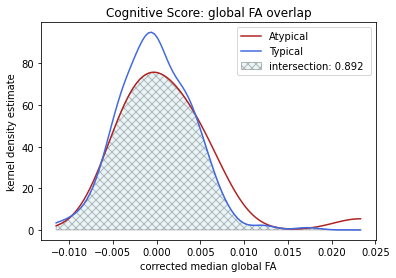

In [5]:
# 2. Select subjects with abnormal vs normal values (thr = 85)
abn = sub_df[sub_df['Cognitive Score'] <= 85]['FA_corr'].values
nrm = sub_df[sub_df['Cognitive Score'] > 85]['FA_corr'].values

# 3. plot & quantify the overlap between the distributions

x = np.linspace(np.min([np.min(abn), np.min(nrm)]),np.max([np.max(abn), np.max(nrm)]),100)
ys = []
for cond, label, color in zip([abn, nrm], ['Atypical', 'Typical'], ['firebrick', 'royalblue']):
    kde_func = gaussian_kde(cond)
    y = kde_func(x)
    plt.plot(x, y, label=label, c=color)
    ys.append(y)
    
y_intersection = np.amin(ys, axis=0)
area = np.trapz(y_intersection, x)
fill_poly = plt.fill_between(x, 0, y_intersection, fc='lightblue', ec='black', alpha=0.25,
                             label=f'intersection: {area:.3f} ')
fill_poly.set_hatch('xxx')
plt.title('Cognitive Score: global FA overlap')
plt.xlabel('corrected median global FA')
plt.ylabel('kernel density estimate')
plt.legend()
plt.show()

The above suggests quite a large overlap between FA values of abnormal and normal subjects for cognitive scores. 

# BSID-III scores 
##  BSID-III scores & Global FA 

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Cognitive Score: number of at risk subjects: 24 vs normal: 271
Language Score: number of at risk subjects: 57 vs normal: 238
Motor Score: number of at risk subjects: 21 vs normal: 274


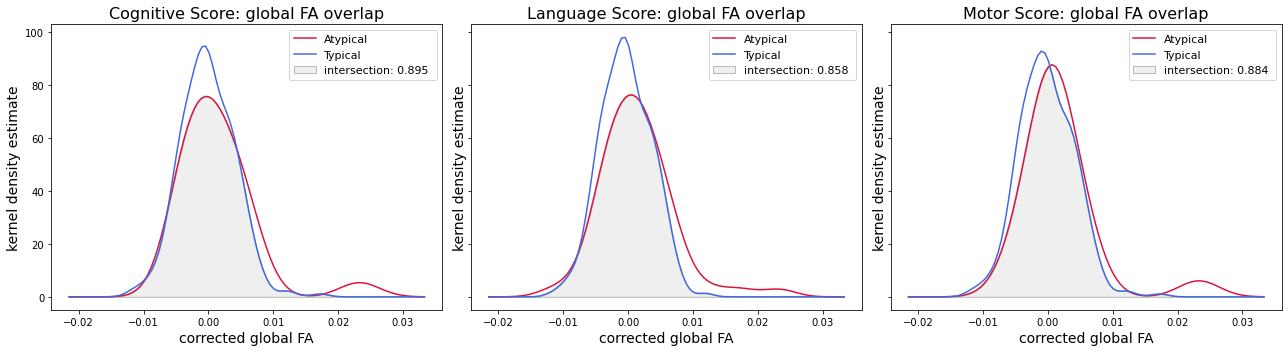

In [6]:
sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction
middle = 36
x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

sub_df['FA_corr'] = residuals.tolist()
###

fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 5))

for pos, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    abn = sub_df[sub_df[score] <= 85]['FA_corr'].values
    nrm = sub_df[sub_df[score] > 85]['FA_corr'].values

    print('{}: number of at risk subjects: {} vs normal: {}'.format(score, len(abn), len(nrm)))
    
    x = np.linspace(np.min(sub_df['FA_corr'].values)-0.01,np.max(sub_df['FA_corr'].values+0.01),100)
    ys = []
    for cond, label, color in zip([abn, nrm], ['Atypical', 'Typical'], ['crimson', 'royalblue']):
        kde_func = gaussian_kde(cond)
        y = kde_func(x)
        axs[pos].plot(x, y, label=label, c=color)
        ys.append(y)
        
    y_intersection = np.amin(ys, axis=0)
    area = np.trapz(y_intersection, x)
    fill_poly = axs[pos].fill_between(x, 0, y_intersection, fc='silver', ec='black', alpha=0.25,
                             label=f'intersection: {area:.3f} ')
    axs[pos].legend(loc='upper right', fontsize=11)
        
    axs[pos].set_title('{}: global FA overlap'.format(score), fontsize=16)
    axs[pos].set_xlabel('corrected global FA', fontsize=14)
    axs[pos].set_ylabel('kernel density estimate', fontsize=14)

plt.tight_layout()
plt.savefig('../../Results/figures/overalap_scores_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show()

##  BSID-III scores & Regional FA

In [7]:
df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

cols = [col for col in df.columns if 'FA' in col]
df = df[df.subject_id.isin(cohorts['A'])]
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in cols]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]
df = pd.merge(df, info[['subject_id', 'session_id','Cognitive Score', 'Language Score', 'Motor Score']], on=['subject_id', 'session_id'])

### get PMA at scan 
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info[['subject_id', 'session_id', 'PMA_scan']], on=['subject_id', 'session_id'])

In [8]:
res = {}
for score in ['Cognitive Score', 'Language Score', 'Motor Score']:
    res[score] = []
    
sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction needs to be done per column
middle = 36
x0 = np.array([np.nanmin(sub_df['PMA_scan'].values), middle, np.nanmax(sub_df['PMA_scan'].values)])

for col in cols:
    
    ### inpute median 
    md = np.nanmedian(sub_df[col].values)
    sub_df[col].fillna(md, inplace=True)
    
    
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df[col].values)
    myPWLF.fit_with_breaks(x0)
    
    yHat = myPWLF.predict(sub_df['PMA_scan'].values)
    residuals = sub_df[col].values - yHat

    sub_df[col+'_corr'] = residuals.tolist()

for pos, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    
    for col in cols: 
        
        col = col+'_corr'
        
        abn = sub_df[sub_df[score] <= 85][col].values
        abn = abn[~np.isnan(abn)]
        nrm = sub_df[sub_df[score] > 85][col].values
        nrm = nrm[~np.isnan(nrm)]
        x = np.linspace(np.nanmin(sub_df[col].values)-0.01,np.nanmax(sub_df[col].values+0.01),100)
        ys = []
        for cond, label, color in zip([abn, nrm], ['At risk', 'Normal'], ['darkmagenta', 'chocolate']):
            kde_func = gaussian_kde(cond[~np.isnan(cond)])
            y = kde_func(x)
            ys.append(y)
        
        y_intersection = np.amin(ys, axis=0)
        area = np.trapz(y_intersection, x)
        
        res[score].append(area)

In [9]:
for score in ['Cognitive Score', 'Language Score', 'Motor Score']:
    print(score)
    for overlap, name in zip(res[score], names):
        if overlap < 0.8:
            print(name,':', overlap)

Cognitive Score
PrCu Right : 0.784920434116475
SOG Right : 0.7499796131157058
CingG Left : 0.7808815196889551
Language Score
SOG Right : 0.7990073985124363
Motor Score
RG Right : 0.7673502607669831
FuG Right : 0.7616830187321244
PHG Right : 0.75546289230216
MOG Right : 0.7486752179277065
PoCG Left : 0.7905666240594538
FuG Left : 0.7620239457255973
PHG Left : 0.7395554282107026


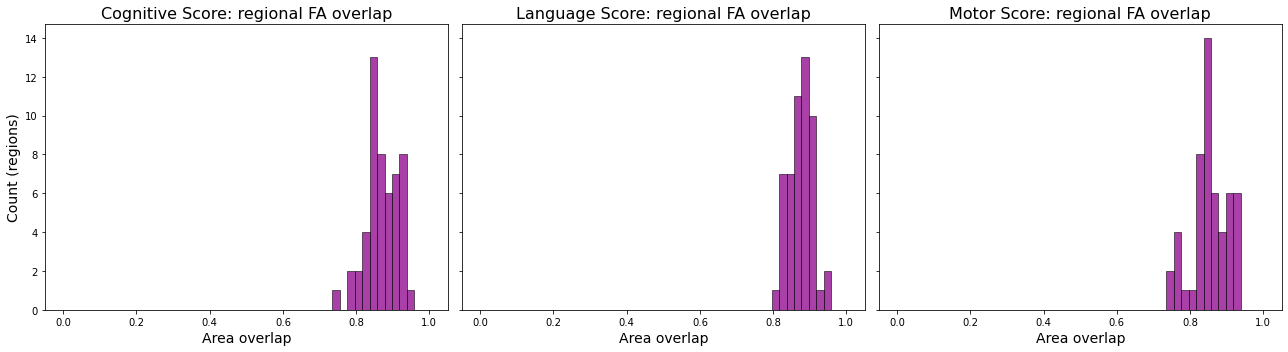

In [10]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 5))
for pos, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    sns.histplot(res[score], ax=axs[pos], kde=False, bins=np.linspace(0,1,50), color='darkmagenta')
    axs[pos].set_title('{}: regional FA overlap'.format(score), fontsize=16)
    axs[pos].set_xlabel('Area overlap', fontsize=14)
    axs[pos].set_ylabel('Count (regions)', fontsize=14)

plt.tight_layout()
plt.savefig('../../Results/figures/overlap_regional_scores_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show()  

## Quantify number of subjects per group
Additionaly, get the proportion of PT and FT subjects (vs the whole PT/FT) for the abnormal, normal scores. 

In [11]:
#df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics.csv', index_col=0)
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)

with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)
    
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id', 'session_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'


for cohort in ['A', 'C', 'D']:

    sub_df = df[df.subject_id.isin(cohorts[cohort])]

    print(cohort)
    print('Number of subjects: {}'.format(len(sub_df)))
    for outcome in ['Cognitive Score', 'Language Score', 'Motor Score']:
        print(outcome)
        print('Number of abnormal: {} (PT: {} ({:.3f}%); FT: {} ({:.3f}%)) '.format( len(sub_df[sub_df[outcome] <= 85]), 
                                                  len(sub_df[(sub_df[outcome] <= 85) & (sub_df['group'] == 'PT')]), 
                                                len(sub_df[(sub_df[outcome] <= 85) & (sub_df['group'] == 'PT')])/len(sub_df[sub_df['group'] == 'PT']), 
                                                  len(sub_df[(sub_df[outcome] <= 85) & (sub_df['group'] == 'FT')]), 
                                                len(sub_df[(sub_df[outcome] <= 85) & (sub_df['group'] == 'FT')])/len(sub_df[sub_df['group'] == 'FT']),
     
                                         ))
    
        print('Number of normal: {} (PT: {} ({:.3f}%); FT: {} ({:.3f}%)) '.format( len(sub_df[sub_df[outcome] > 85]), 
                                                  len(sub_df[(sub_df[outcome] > 85) & (sub_df['group'] == 'PT')]), 
                                                len(sub_df[(sub_df[outcome] > 85) & (sub_df['group'] == 'PT')])/len(sub_df[sub_df['group'] == 'PT']), 
                                                  len(sub_df[(sub_df[outcome] > 85) & (sub_df['group'] == 'FT')]), 
                                                len(sub_df[(sub_df[outcome] > 85) & (sub_df['group'] == 'FT')])/len(sub_df[sub_df['group'] == 'FT']),
     
                                         ))
    print('\n')

A
Number of subjects: 295
Cognitive Score
Number of abnormal: 24 (PT: 4 (0.093%); FT: 20 (0.079%)) 
Number of normal: 271 (PT: 39 (0.907%); FT: 232 (0.921%)) 
Language Score
Number of abnormal: 57 (PT: 7 (0.163%); FT: 50 (0.198%)) 
Number of normal: 238 (PT: 36 (0.837%); FT: 202 (0.802%)) 
Motor Score
Number of abnormal: 21 (PT: 5 (0.116%); FT: 16 (0.063%)) 
Number of normal: 274 (PT: 38 (0.884%); FT: 236 (0.937%)) 


C
Number of subjects: 196
Cognitive Score
Number of abnormal: 20 (PT: 4 (0.103%); FT: 16 (0.102%)) 
Number of normal: 176 (PT: 35 (0.897%); FT: 141 (0.898%)) 
Language Score
Number of abnormal: 42 (PT: 6 (0.154%); FT: 36 (0.229%)) 
Number of normal: 154 (PT: 33 (0.846%); FT: 121 (0.771%)) 
Motor Score
Number of abnormal: 17 (PT: 5 (0.128%); FT: 12 (0.076%)) 
Number of normal: 179 (PT: 34 (0.872%); FT: 145 (0.924%)) 


D
Number of subjects: 126
Cognitive Score
Number of abnormal: 16 (PT: 2 (0.095%); FT: 14 (0.133%)) 
Number of normal: 110 (PT: 19 (0.905%); FT: 91 (0.867%))

# PREMATURITY status 
## PREMATURITY status & Global FA 

In [12]:
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id', 'session_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'
### combine hemispheres 
metrics = ['FA']#, 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in df.iterrows():
        df.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])

Number of at PT subjects: 43 vs FT: 252


/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


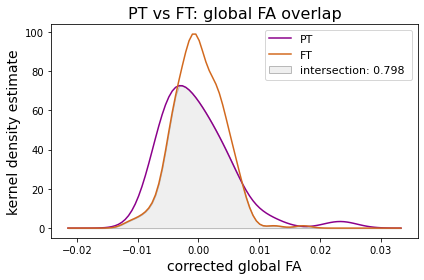

In [13]:
sub_df = df[df.subject_id.isin(cohorts['A'])]

middle = 36
x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

sub_df['FA_corr'] = residuals.tolist()


abn = sub_df[sub_df['group'] == 'PT']['FA_corr'].values
nrm = sub_df[sub_df['group'] == 'FT']['FA_corr'].values

print('Number of at PT subjects: {} vs FT: {}'.format(len(abn), len(nrm)))
    
x = np.linspace(np.min(sub_df['FA_corr'].values)-0.01,np.max(sub_df['FA_corr'].values+0.01),100)
ys = []
for cond, label, color in zip([abn, nrm], ['PT', 'FT'], ['darkmagenta', 'chocolate']):
    kde_func = gaussian_kde(cond)
    y = kde_func(x)
    plt.plot(x, y, label=label, c=color)
    ys.append(y)
        
y_intersection = np.amin(ys, axis=0)
area = np.trapz(y_intersection, x)
fill_poly = plt.fill_between(x, 0, y_intersection, fc='silver', ec='black', alpha=0.25,
                             label=f'intersection: {area:.3f} ')
plt.legend(loc='upper right', fontsize=11)
        
plt.title('PT vs FT: global FA overlap'.format(score), fontsize=16)
plt.xlabel('corrected global FA', fontsize=14)
plt.ylabel('kernel density estimate', fontsize=14)


plt.tight_layout()
plt.savefig('../../Results/figures/overlap_preterm_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show() 

plt.show()

## PREMATURITY status & Regional FA 

In [14]:
## per segmented region
df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

cols = [col for col in df.columns if 'FA' in col]
df = df[df.subject_id.isin(cohorts['A'])]
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in cols]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]
df = pd.merge(df, info[['subject_id', 'session_id','GA_birth', 'PMA_scan']], on=['subject_id', 'session_id'])

df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

In [15]:
res = []

sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction needs to be done per column
middle = 36
x0 = np.array([np.nanmin(sub_df['PMA_scan'].values), middle, np.nanmax(sub_df['PMA_scan'].values)])

for col in cols:
    
    ### unpute median 
    md = np.nanmedian(sub_df[col].values)
    sub_df[col].fillna(md, inplace=True)
    
    
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df[col].values)
    myPWLF.fit_with_breaks(x0)
    
    yHat = myPWLF.predict(sub_df['PMA_scan'].values)
    residuals = sub_df[col].values - yHat

    sub_df[col+'_corr'] = residuals.tolist()

for col in cols: 
    
    col = col+'_corr'
    abn = sub_df[sub_df['group'] == 'PT'][col].values
    nrm = sub_df[sub_df['group'] == 'FT'][col].values
    abn = abn[~np.isnan(abn)]
    nrm = nrm[~np.isnan(nrm)]
    x = np.linspace(np.nanmin(sub_df[col].values)-0.01,np.nanmax(sub_df[col].values+0.01),100)
    ys = []
    for cond, label, color in zip([abn, nrm], ['At risk', 'Normal'], ['darkmagenta', 'chocolate']):
        kde_func = gaussian_kde(cond[~np.isnan(cond)])
        y = kde_func(x)
        ys.append(y)
        
    y_intersection = np.amin(ys, axis=0)
    area = np.trapz(y_intersection, x)
        
    res.append(area)

In [16]:
for overlap, name in zip(res, names):
    if overlap < 0.8:
        print(name,':', overlap)

SPL Right : 0.723887371584242
AG Right : 0.7185745806296009
MTG Right : 0.746785459695738
ITG Right : 0.7897681627010824
SOG Right : 0.7684688613525347
MOG Right : 0.7753234564957928
MFG Left : 0.7700005662929844
IFG Left : 0.7432440268868414
SPL Left : 0.7402478719982707
ENT Left : 0.7848726504633893
SOG Left : 0.7352608017039202
Cu Left : 0.7639722250604236
LG Left : 0.791763828222527


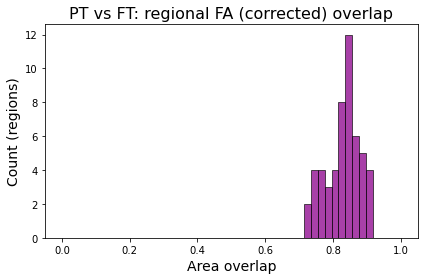

In [17]:
sns.histplot(res, kde=False, bins=np.linspace(0,1,50), color='darkmagenta')
plt.title('PT vs FT: regional FA (corrected) overlap'.format(score), fontsize=16)
plt.xlabel('Area overlap', fontsize=14)
plt.ylabel('Count (regions)', fontsize=14)

plt.tight_layout()
plt.savefig('../../Results/figures/overlap_regional_preterm_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show() 

plt.show()  

## combined 

/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/volatile/miniconda3/envs/ohbm/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Number of at PT subjects: 43 vs FT: 252
Cognitive Score: number of at risk subjects: 24 vs normal: 271
Language Score: number of at risk subjects: 57 vs normal: 238
Motor Score: number of at risk subjects: 21 vs normal: 274


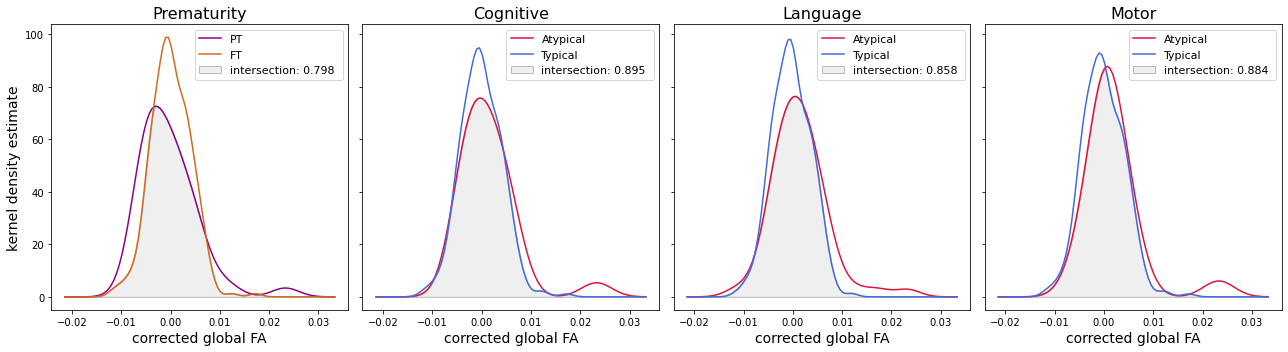

In [56]:
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id', 'session_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'
### combine hemispheres 
metrics = ['FA']#, 'L1', 'RD', 'MD']
hemispheres = ['left', 'right']
for metric in metrics:
    for i, row in df.iterrows():
        df.loc[i,metric] = np.mean([row['left_{}'.format(metric)], 
                                   row['right_{}'.format(metric)]])
        
        
sub_df = df[df.subject_id.isin(cohorts['A'])]

middle = 36
x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

sub_df['FA_corr'] = residuals.tolist()


abn = sub_df[sub_df['group'] == 'PT']['FA_corr'].values
nrm = sub_df[sub_df['group'] == 'FT']['FA_corr'].values

print('Number of at PT subjects: {} vs FT: {}'.format(len(abn), len(nrm)))
    
x = np.linspace(np.min(sub_df['FA_corr'].values)-0.01,np.max(sub_df['FA_corr'].values+0.01),100)
ys = []

fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(18, 5))


for cond, label, color in zip([abn, nrm], ['PT', 'FT'], ['darkmagenta', 'chocolate']):
    kde_func = gaussian_kde(cond)
    y = kde_func(x)
    axs[0].plot(x, y, label=label, c=color)
    ys.append(y)
        
y_intersection = np.amin(ys, axis=0)
area = np.trapz(y_intersection, x)
fill_poly = axs[0].fill_between(x, 0, y_intersection, fc='silver', ec='black', alpha=0.25,
                             label=f'intersection: {area:.3f} ')
axs[0].legend(loc='upper right', fontsize=11)
        
#plt.title('PT vs FT: global FA overlap'.format(score), fontsize=16)
axs[0].set_title('Prematurity', fontsize=16)
axs[0].set_xlabel('corrected global FA', fontsize=14)
axs[0].set_ylabel('kernel density estimate', fontsize=14)

sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction
middle = 36
x0 = np.array([min(sub_df['PMA_scan'].values), middle, max(sub_df['PMA_scan'].values)])
myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df['FA'].values)
myPWLF.fit_with_breaks(x0)

yHat = myPWLF.predict(sub_df['PMA_scan'].values)
residuals = sub_df['FA'].values - yHat

sub_df['FA_corr'] = residuals.tolist()
###

#fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 5))

names = ['Cognitive', 'Language', 'Motor']

for p, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    pos = p + 1 
    
    abn = sub_df[sub_df[score] <= 85]['FA_corr'].values
    nrm = sub_df[sub_df[score] > 85]['FA_corr'].values

    print('{}: number of at risk subjects: {} vs normal: {}'.format(score, len(abn), len(nrm)))
    
    x = np.linspace(np.min(sub_df['FA_corr'].values)-0.01,np.max(sub_df['FA_corr'].values+0.01),100)
    ys = []
    for cond, label, color in zip([abn, nrm], ['Atypical', 'Typical'], ['crimson', 'royalblue']):
        kde_func = gaussian_kde(cond)
        y = kde_func(x)
        axs[pos].plot(x, y, label=label, c=color)
        ys.append(y)
        
    y_intersection = np.amin(ys, axis=0)
    area = np.trapz(y_intersection, x)
    fill_poly = axs[pos].fill_between(x, 0, y_intersection, fc='silver', ec='black', alpha=0.25,
                             label=f'intersection: {area:.3f} ')
    axs[pos].legend(loc='upper right', fontsize=11)
        
    axs[pos].set_title(names[p], fontsize=16)
    axs[pos].set_xlabel('corrected global FA', fontsize=14)
    #axs[pos].set_ylabel('kernel density estimate', fontsize=14)


plt.tight_layout()
plt.savefig('../../Results/figures/overlap_preterm_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show() 



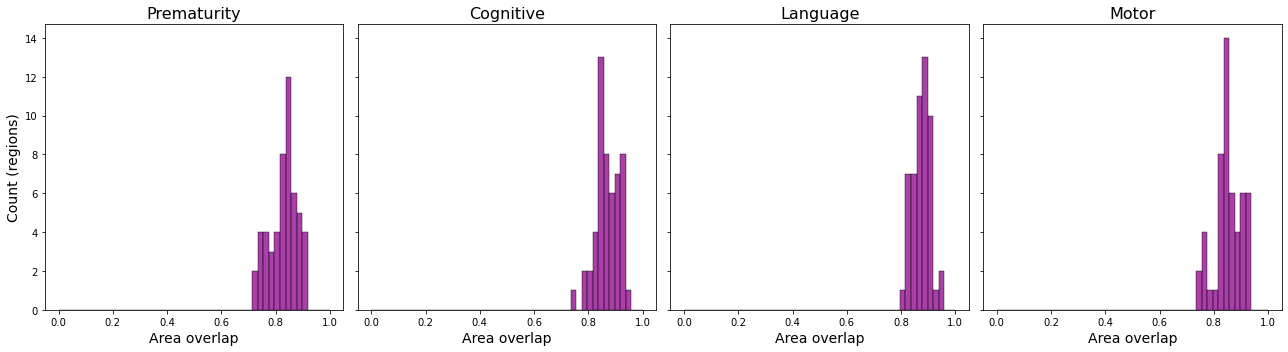

In [64]:
## per segmented region
df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

cols = [col for col in df.columns if 'FA' in col]
df = df[df.subject_id.isin(cohorts['A'])]
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in cols]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]
df = pd.merge(df, info[['subject_id', 'session_id','GA_birth', 'PMA_scan']], on=['subject_id', 'session_id'])

df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

res = []

sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction needs to be done per column
middle = 36
x0 = np.array([np.nanmin(sub_df['PMA_scan'].values), middle, np.nanmax(sub_df['PMA_scan'].values)])

for col in cols:
    
    ### unpute median 
    md = np.nanmedian(sub_df[col].values)
    sub_df[col].fillna(md, inplace=True)
    
    
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df[col].values)
    myPWLF.fit_with_breaks(x0)
    
    yHat = myPWLF.predict(sub_df['PMA_scan'].values)
    residuals = sub_df[col].values - yHat

    sub_df[col+'_corr'] = residuals.tolist()

for col in cols: 
    
    col = col+'_corr'
    abn = sub_df[sub_df['group'] == 'PT'][col].values
    nrm = sub_df[sub_df['group'] == 'FT'][col].values
    abn = abn[~np.isnan(abn)]
    nrm = nrm[~np.isnan(nrm)]
    x = np.linspace(np.nanmin(sub_df[col].values)-0.01,np.nanmax(sub_df[col].values+0.01),100)
    ys = []
    for cond, label, color in zip([abn, nrm], ['At risk', 'Normal'], ['darkmagenta', 'chocolate']):
        kde_func = gaussian_kde(cond[~np.isnan(cond)])
        y = kde_func(x)
        ys.append(y)
        
    y_intersection = np.amin(ys, axis=0)
    area = np.trapz(y_intersection, x)
        
    res.append(area)
 
fig, axs = plt.subplots(1,4, sharex=True, sharey=True, figsize=(18, 5))

sns.histplot(res, kde=False, bins=np.linspace(0,1,50), color='darkmagenta', ax=axs[0])
axs[0].set_title('Prematurity'.format(score), fontsize=16)
axs[0].set_xlabel('Area overlap', fontsize=14)
axs[0].set_ylabel('Count (regions)', fontsize=14)

df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

cols = [col for col in df.columns if 'FA' in col]
df = df[df.subject_id.isin(cohorts['A'])]
scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in cols]
names = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]
df = pd.merge(df, info[['subject_id', 'session_id','Cognitive Score', 'Language Score', 'Motor Score']], on=['subject_id', 'session_id'])

### get PMA at scan 
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info[['subject_id', 'session_id', 'PMA_scan']], on=['subject_id', 'session_id'])

res = {}
for score in ['Cognitive Score', 'Language Score', 'Motor Score']:
    res[score] = []
    
sub_df = df[df.subject_id.isin(cohorts['A'])]

### age correction needs to be done per column
middle = 36
x0 = np.array([np.nanmin(sub_df['PMA_scan'].values), middle, np.nanmax(sub_df['PMA_scan'].values)])

for col in cols:
    
    ### inpute median 
    md = np.nanmedian(sub_df[col].values)
    sub_df[col].fillna(md, inplace=True)
    
    
    myPWLF = pwlf.PiecewiseLinFit(sub_df['PMA_scan'].values,sub_df[col].values)
    myPWLF.fit_with_breaks(x0)
    
    yHat = myPWLF.predict(sub_df['PMA_scan'].values)
    residuals = sub_df[col].values - yHat

    sub_df[col+'_corr'] = residuals.tolist()

for pos, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    
    for col in cols: 
        
        col = col+'_corr'
        
        abn = sub_df[sub_df[score] <= 85][col].values
        abn = abn[~np.isnan(abn)]
        nrm = sub_df[sub_df[score] > 85][col].values
        nrm = nrm[~np.isnan(nrm)]
        x = np.linspace(np.nanmin(sub_df[col].values)-0.01,np.nanmax(sub_df[col].values+0.01),100)
        ys = []
        for cond, label, color in zip([abn, nrm], ['At risk', 'Normal'], ['darkmagenta', 'chocolate']):
            kde_func = gaussian_kde(cond[~np.isnan(cond)])
            y = kde_func(x)
            ys.append(y)
        
        y_intersection = np.amin(ys, axis=0)
        area = np.trapz(y_intersection, x)
        
        res[score].append(area)
        
names = ['Cognitive', 'Language', 'Motor']
#fig, axs = plt.subplots(1,3, sharex=True, sharey=True, figsize=(18, 5))
for p, score in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    
    pos = p+1
    sns.histplot(res[score], ax=axs[pos], kde=False, bins=np.linspace(0,1,50), color='darkmagenta')
    axs[pos].set_title(names[p], fontsize=16)
    axs[pos].set_xlabel('Area overlap', fontsize=14)
    axs[pos].set_ylabel('Count (regions)', fontsize=14)

plt.tight_layout()
plt.savefig('../../Results/figures/overlap_regional_scores_cohortA.png', dpi=500, facecolor='white', transparent=False)
plt.show()  

## Collinearity between regional FA

In [18]:
### ages
df = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)

### median FA regions 
new_df = pd.read_csv('../../DerivedData/extracted_metrics/neonat_segmentation_diffusion_metric_median.csv', index_col=0)

FA_cols = [col for col in new_df.columns if 'FA' in col]
FA_cols.extend(['subject_id'])

#new_df = df.copy()
new_df = pd.merge(new_df, df[['subject_id', 'PMA_scan', 'GA_birth', 
                                'Cognitive Score', 'Language Score', 'Motor Score']], on=['subject_id'])


with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)
    
new_df = new_df[new_df.subject_id.isin(cohorts['A'])]    

In [19]:
def corr_sig(test_df=None):
    test_df.dropna(inplace=True)
    
    p_matrix = np.zeros(shape=(test_df.shape[1], test_df.shape[1]))
    
    p_for_cor = []
    for col in test_df.columns:
        for col2 in test_df.drop(col,axis=1).columns:

            p = pg.corr(test_df[col],test_df[col2])['p-val'][0].astype(np.float64)
            p_for_cor.append(p)
            
    _, p_cor = pg.multicomp(p_for_cor, method='FDR_bh')    
    
    i=0
    for col in test_df.columns:
        for col2 in test_df.drop(col,axis=1).columns:
            
            p_matrix[test_df.columns.to_list().index(col),test_df.columns.to_list().index(col2)] = p_cor[i]
            i = i + 1
            
    return p_matrix


### Pre-PMA_scan correction

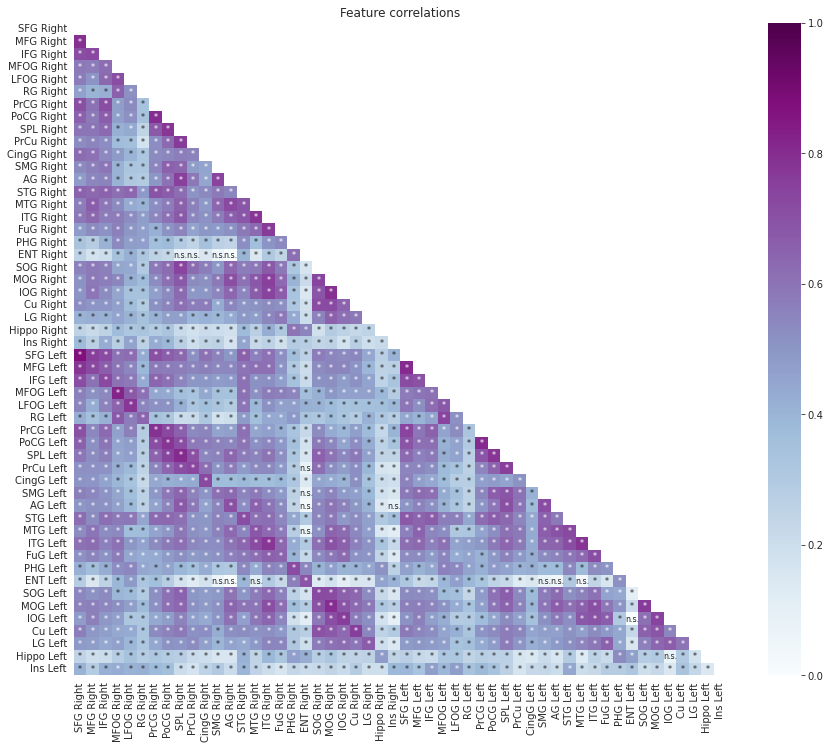

In [20]:
pre_corr = new_df[FA_cols[:-1]].corr()
mask = np.zeros_like(pre_corr)
mask[np.triu_indices_from(mask)] = True

p_mat = corr_sig(test_df=new_df[FA_cols[:-1]].copy())

scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in FA_cols[:-1]]
tick_labels = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(pre_corr, vmin=0, vmax=1, square=True, mask =mask, 
                    xticklabels=tick_labels, yticklabels=tick_labels, 
                    annot=p_mat, annot_kws={"size":8}, cmap="BuPu")
    
    for t in ax.texts:
        if np.float64(t.get_text()) < 0.05:
            t.set_text("*")
        else: 
            t.set_text("n.s.")
        #if 
        #t.set_text(t.get_text() + " %")
plt.title('Feature correlations')
plt.show()

### Post-PMA_scan correction

In [21]:
## same but after correction for PMA at scan 
inflection = 36
df_corrected = new_df[FA_cols[:-1]+['PMA_scan']].copy().dropna()
x0 = np.array([min(df_corrected['PMA_scan']), inflection, max(df_corrected['PMA_scan'])])

for col in df_corrected.columns[:-1]:
    myPWLF = pwlf.PiecewiseLinFit(df_corrected['PMA_scan'].values, df_corrected[col].values)
    myPWLF.fit_with_breaks(x0)
        
    ## correct train 
    yHat_train = myPWLF.predict(df_corrected['PMA_scan'].values)
    res_train = df_corrected[col].values - yHat_train
    df_corrected[col] = res_train

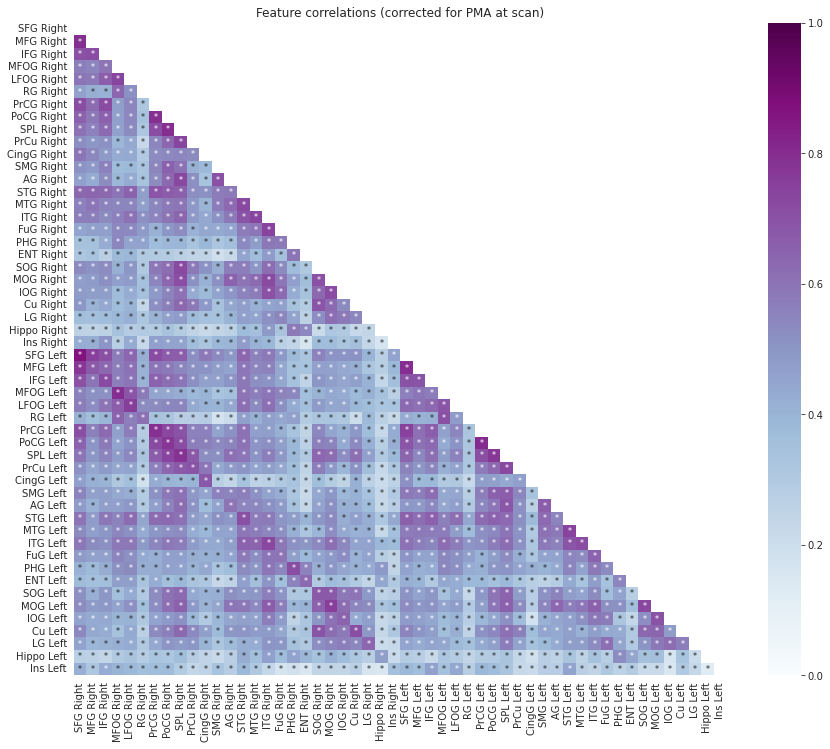

In [22]:
post_corr = df_corrected[FA_cols[:-1]].corr()

mask = np.zeros_like(post_corr)
mask[np.triu_indices_from(mask)] = True

p_mat = corr_sig(test_df=df_corrected[FA_cols[:-1]].copy())

scheme = pd.read_csv('../../SourceData/atlas_labelling_scheme.csv')

lbs = [name.split('_')[1] for name in FA_cols[:-1]]
tick_labels = [scheme[scheme.Label == int(l)]['Abbreviation'].values[0] + ' ' +  scheme[scheme.Label == int(l)]['Hemisphere'].values[0]for l in lbs]


with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 12))
    ax = sns.heatmap(post_corr, vmin=0, vmax=1, square=True, mask =mask, 
                    xticklabels=tick_labels, yticklabels=tick_labels, 
                    annot=p_mat, annot_kws={"size":8}, cmap="BuPu")
    
    for t in ax.texts:
        if np.float64(t.get_text()) < 0.05:
            t.set_text("*")
        else: 
            t.set_text("n.s.")
        #if 
        #t.set_text(t.get_text() + " %")
plt.title('Feature correlations (corrected for PMA at scan)')
plt.show()

## Plot regional FA distribution 

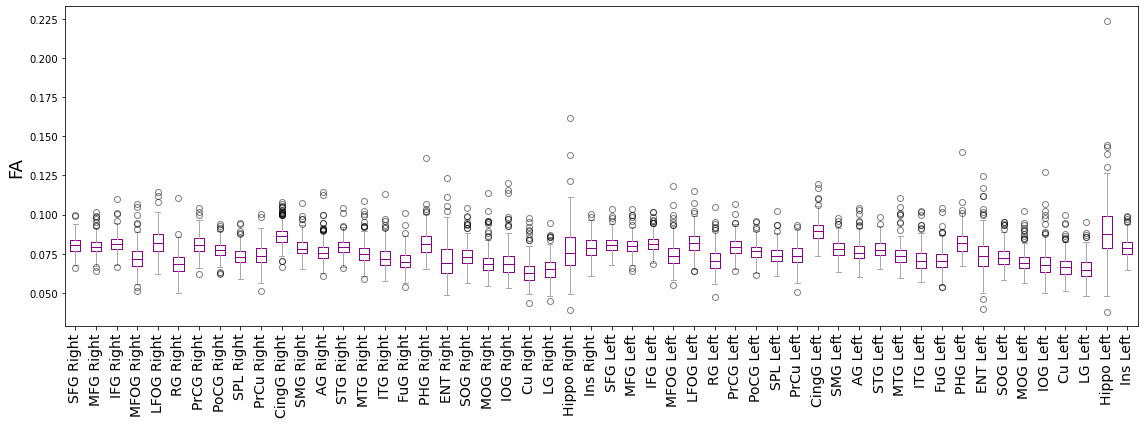

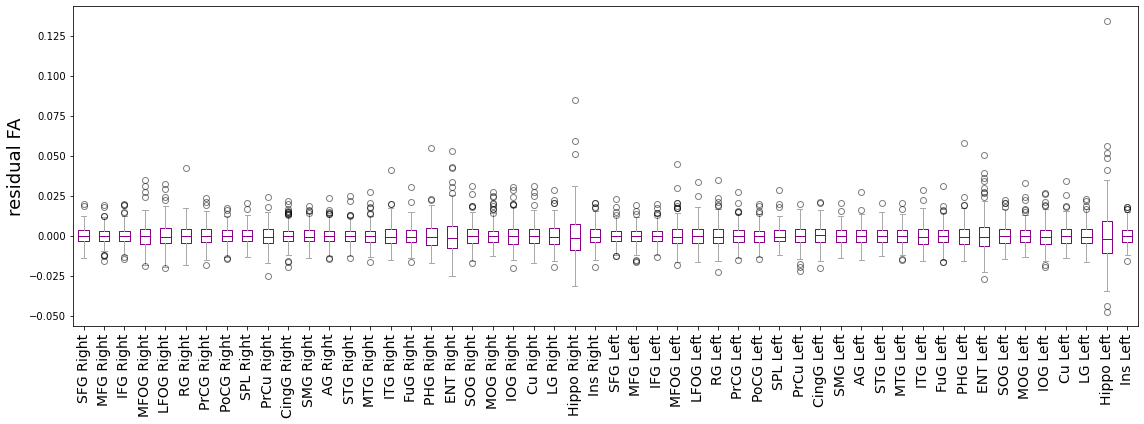

In [23]:
new_df = new_df.dropna()

plt.figure(figsize=(16,6))
bpl = plt.boxplot(new_df[FA_cols[:-1]], labels=tick_labels)
set_box_color(bpl, 'darkmagenta')
plt.xticks(rotation=90, fontsize=14)
plt.ylabel('FA', fontsize=18 )
fig.set_facecolor("white")
plt.tight_layout()
plt.savefig('../../Results/figures/regional_FA_distribution.png', dpi=500, facecolor='white', transparent=False)
plt.show()

plt.figure(figsize=(16,6))
bpl = plt.boxplot(df_corrected[FA_cols[:-1]], labels=tick_labels)
set_box_color(bpl, 'darkmagenta')
plt.xticks(rotation=90, fontsize=14)
plt.ylabel('residual FA', fontsize=18 )
fig.set_facecolor("white")
plt.tight_layout()
plt.savefig('../../Results/figures/regional_residual_FA_distribution.png', dpi=500, facecolor='white', transparent=False)
plt.show()

## PCA 

In [24]:
from sklearn.decomposition import PCA 

In [25]:
pca = PCA(n_components=len(FA_cols[:-1]))
pca.fit(new_df[FA_cols[:-1]].values)

trf = pca.transform(new_df[FA_cols[:-1]].values)

In [26]:
new_df['group'] = 'FT'
new_df.loc[new_df['GA_birth'] <= 37, 'group'] = 'PT' 

for outcome in ['Cognitive Score', 'Language Score', 'Motor Score']:
    new_df[outcome.split(' ')[0] + '_cat'] = 'Typical'
    new_df.loc[new_df[outcome] <= 85, outcome.split(' ')[0] + '_cat'] = 'Atypical' 


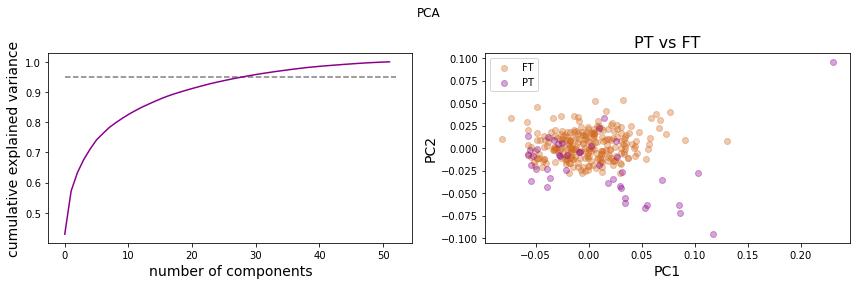

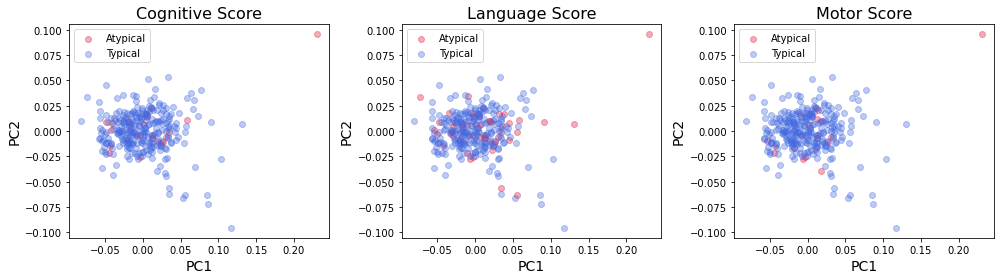

In [27]:
fig, axs = plt.subplots(1,2,  figsize=(12,4))

axs[0].plot(np.cumsum(pca.explained_variance_ratio_),  color='darkmagenta')
axs[0].set_xlabel('number of components', fontsize=14)
axs[0].set_ylabel('cumulative explained variance', fontsize=14)
axs[0].hlines(.95,0,len(pca.explained_variance_ratio_),  color='gray', linestyle= '--')

group = new_df['group'].values
cdict = {'FT' : 'chocolate', 'PT' : 'darkmagenta'}

for g in np.unique(group):
    ix = np.where(group == g)
    axs[1].scatter(trf[ix,0], trf[ix,1], c = cdict[g], label = g, alpha=0.35)
axs[1].set_xlabel('PC1', fontsize=14)
axs[1].set_ylabel('PC2', fontsize=14)
axs[1].legend()
axs[1].set_title('PT vs FT', fontsize=16)

plt.suptitle('PCA')
plt.tight_layout()
plt.savefig('../../Results/figures/PCA_preterms.png', dpi=500, facecolor='white', transparent=False)
plt.show()

fig, axs = plt.subplots(1,3,  figsize=(14,4))

for i, outcome in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    out = outcome.split(' ')[0] + '_cat'

    group = new_df[out].values
    cdict = {'Atypical': 'crimson', 'Typical' : 'royalblue'}

    for g in np.unique(group):
        ix = np.where(group == g)
        axs[i].scatter(trf[ix,0], trf[ix,1], c = cdict[g], label = g, alpha=0.35)
        axs[i].set_xlabel('PC1', fontsize=14)
        axs[i].set_ylabel('PC2', fontsize=14)
        axs[i].set_title(outcome, fontsize=16)
        axs[i].legend()

plt.tight_layout()
plt.savefig('../../Results/figures/PCA_scores.png', dpi=500, facecolor='white', transparent=False)
plt.show()

In [28]:
# weird subject
new_df.loc[np.argmax(trf[:,1])]

subject_id       CC00097XX16
session_id             33701
left_68_FA          0.091121
left_70_FA          0.089021
left_72_FA          0.100612
                    ...     
Motor Score             94.0
group                     FT
Cognitive_cat        Typical
Language_cat        Atypical
Motor_cat            Typical
Name: 19, Length: 219, dtype: object

## Relationship with ages 

In [29]:
#new_df = pd.merge(new_df, df[['subject_id', 'GA_birth']], on=['subject_id'])

           n         r          CI95%     p-val   BF10    power
pearson  292 -0.076195  [-0.19, 0.04]  0.194178  0.169  0.25506
           n         r          CI95%    p-val   BF10     power
pearson  292 -0.080549  [-0.19, 0.03]  0.16983  0.187  0.279441


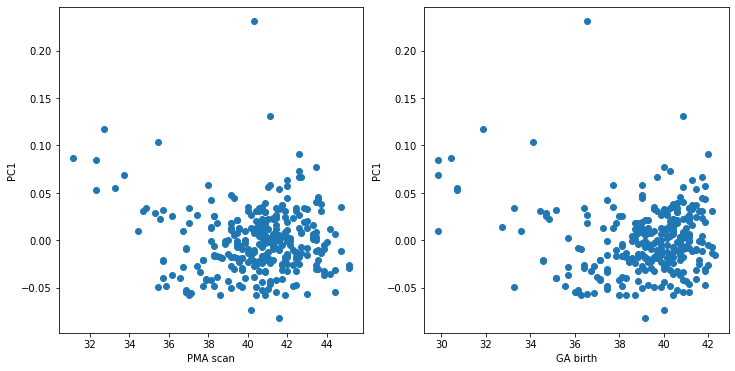

In [30]:
f, axs = plt.subplots(1,2, figsize=(12, 6))

axs[0].scatter(new_df.PMA_scan.values, trf[:,0])
test = pg.corr(new_df.PMA_scan.values, trf[:,0])
print(test)

axs[1].scatter(new_df.GA_birth.values, trf[:,0])
test = pg.corr(new_df.GA_birth.values, trf[:,0])
print(test)

axs[0].set_ylabel('PC1')
axs[1].set_ylabel('PC1')

axs[0].set_xlabel('PMA scan')
axs[1].set_xlabel('GA birth')


plt.show()

## Afer age correction 

In [31]:
## same but after correction for PMA at scan 
inflection = 36
df_corrected = new_df.copy().dropna()

#df_corrected = new_df[FA_cols[:-1]+['PMA_scan']].copy().dropna()
x0 = np.array([min(df_corrected['PMA_scan']), inflection, max(df_corrected['PMA_scan'])])

for col in FA_cols[:-1]:
    myPWLF = pwlf.PiecewiseLinFit(df_corrected['PMA_scan'].values, df_corrected[col].values)
    myPWLF.fit_with_breaks(x0)
        
    ## correct train 
    yHat_train = myPWLF.predict(df_corrected['PMA_scan'].values)
    res_train = df_corrected[col].values - yHat_train
    df_corrected[col] = res_train

In [32]:
pca = PCA(n_components=len(FA_cols[:-1]))
pca.fit(df_corrected[FA_cols[:-1]].values)

trf = pca.transform(df_corrected[FA_cols[:-1]].values)



           n             r          CI95%  p-val   BF10     power
pearson  292 -2.248202e-15  [-0.11, 0.11]    1.0  0.073  0.049945
           n         r          CI95%     p-val   BF10     power
pearson  292  0.044889  [-0.07, 0.16]  0.444774  0.098  0.119158


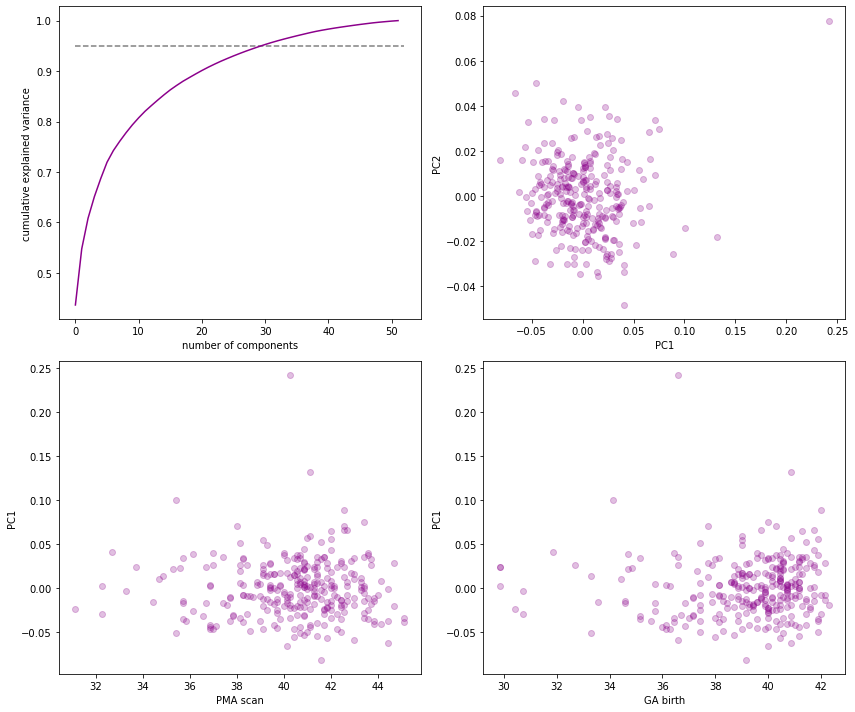

In [33]:
fig, axs = plt.subplots(2,2,  figsize=(12,10))
axs = axs.ravel()

axs[0].plot(np.cumsum(pca.explained_variance_ratio_),  color='darkmagenta')
axs[0].set_xlabel('number of components')
axs[0].set_ylabel('cumulative explained variance')
axs[0].hlines(.95,0,len(pca.explained_variance_ratio_),  color='gray', linestyle= '--')

axs[1].scatter(trf[:,0], trf[:,1], color='darkmagenta', alpha=0.25)
axs[1].set_xlabel('PC1')
axs[1].set_ylabel('PC2')

axs[2].scatter(df_corrected.PMA_scan.values, trf[:,0], color='darkmagenta', alpha=0.25)
test = pg.corr(df_corrected.PMA_scan.values, trf[:,0])
print(test)

axs[3].scatter(df_corrected.GA_birth.values, trf[:,0], color='darkmagenta', alpha=0.25)
test = pg.corr(df_corrected.GA_birth.values, trf[:,0])
print(test)

axs[2].set_ylabel('PC1')
axs[3].set_ylabel('PC1')

axs[2].set_xlabel('PMA scan')
axs[3].set_xlabel('GA birth')


plt.tight_layout()
plt.show()

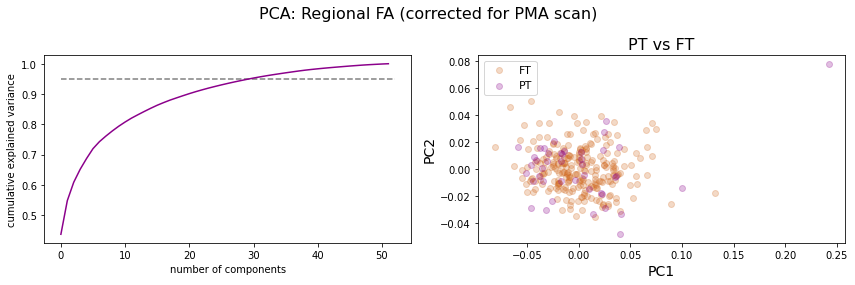

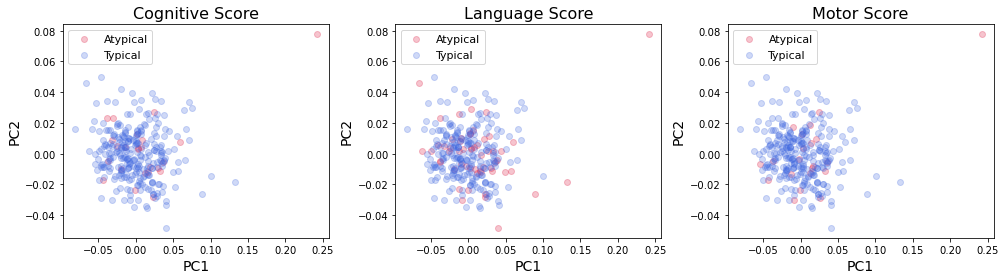

In [63]:
fig, axs = plt.subplots(1,2,  figsize=(12,4))

axs[0].plot(np.cumsum(pca.explained_variance_ratio_),  color='darkmagenta')
axs[0].set_xlabel('number of components')
axs[0].set_ylabel('cumulative explained variance')
axs[0].hlines(.95,0,len(pca.explained_variance_ratio_),  color='gray', linestyle= '--')

group = df_corrected['group'].values
cdict = {'FT' : 'chocolate', 'PT' : 'darkmagenta'}

for g in np.unique(group):
    ix = np.where(group == g)
    axs[1].scatter(trf[ix,0], trf[ix,1], c = cdict[g], label = g, alpha=0.25)
axs[1].set_xlabel('PC1', fontsize=14)
axs[1].set_ylabel('PC2', fontsize=14)
axs[1].legend(fontsize=11)
axs[1].set_title('PT vs FT',fontsize=16)

plt.suptitle('PCA: Regional FA (corrected for PMA scan)', fontsize=16)
plt.tight_layout()
plt.savefig('../../Results/figures/PCA_preterms_age_corrected.png', dpi=500, facecolor='white', transparent=False)
plt.show()

fig, axs = plt.subplots(1,3,  figsize=(14,4))

for i, outcome in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    out = outcome.split(' ')[0] + '_cat'

    group = new_df[out].values
    cdict = {'Atypical': 'crimson', 'Typical' : 'royalblue'}

    for g in np.unique(group):
        ix = np.where(group == g)
        axs[i].scatter(trf[ix,0], trf[ix,1], c = cdict[g], label = g, alpha=0.25)
        axs[i].set_xlabel('PC1',fontsize=14)
        axs[i].set_ylabel('PC2',fontsize=14)
        axs[i].set_title(outcome, fontsize=16)
        axs[i].legend(fontsize=11)

plt.tight_layout()
plt.savefig('../../Results/figures/PCA_scoress_age_corrected.png', dpi=500, facecolor='white', transparent=False)
plt.show()

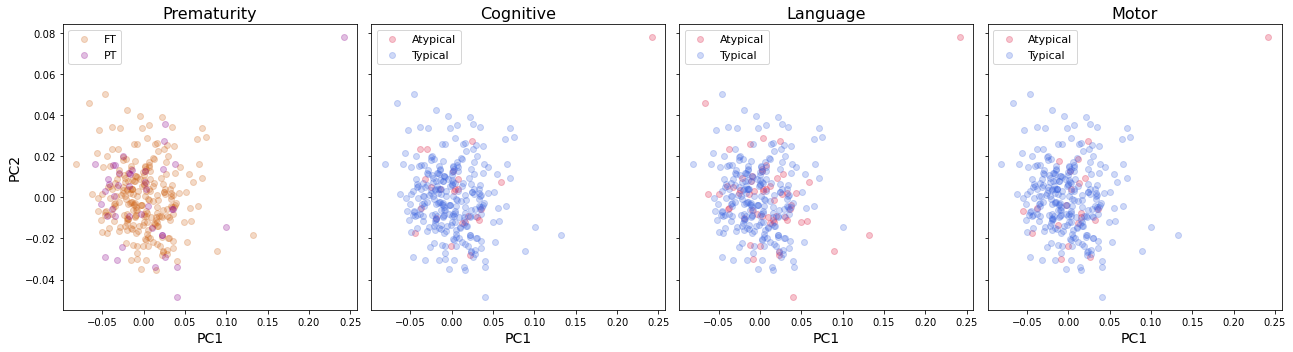

In [57]:
fig, axs = plt.subplots(1,4,  figsize=(18,5), sharex=True, sharey=True)


#axs[0].plot(np.cumsum(pca.explained_variance_ratio_),  color='darkmagenta')
#axs[0].set_xlabel('number of components')
#axs[0].set_ylabel('cumulative explained variance')
#axs[0].hlines(.95,0,len(pca.explained_variance_ratio_),  color='gray', linestyle= '--')

group = df_corrected['group'].values
cdict = {'FT' : 'chocolate', 'PT' : 'darkmagenta'}

for g in np.unique(group):
    ix = np.where(group == g)
    axs[0].scatter(trf[ix,0], trf[ix,1], c = cdict[g], label = g, alpha=0.25)
axs[0].set_xlabel('PC1', fontsize=14)
axs[0].set_ylabel('PC2', fontsize=14)
axs[0].legend(fontsize=11)
axs[0].set_title('Prematurity',fontsize=16)

#plt.suptitle('PCA: Regional FA (corrected for PMA scan)', fontsize=16)
#plt.tight_layout()
#plt.savefig('../../Results/figures/PCA_preterms_age_corrected.png', dpi=500, facecolor='white', transparent=False)
#plt.show()

#fig, axs = plt.subplots(1,3,  figsize=(14,4))
names = ['Cognitive', 'Language', 'Motor']

for f, outcome in enumerate(['Cognitive Score', 'Language Score', 'Motor Score']):
    i = f+1
    out = outcome.split(' ')[0] + '_cat'

    group = new_df[out].values
    cdict = {'Atypical': 'crimson', 'Typical' : 'royalblue'}

    for g in np.unique(group):
        ix = np.where(group == g)
        axs[i].scatter(trf[ix,0], trf[ix,1], c = cdict[g], label = g, alpha=0.25)
        axs[i].set_xlabel('PC1',fontsize=14)
        #axs[i].set_ylabel('PC2',fontsize=14)
        axs[i].set_title(names[f], fontsize=16)
        axs[i].legend(fontsize=11)

plt.tight_layout()
plt.savefig('../../Results/figures/PCA_age_corrected.png', dpi=500, facecolor='white', transparent=False)
plt.show()

## Additional for paper: delay between scan & birth, correlations 

In [64]:
#df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics.csv', index_col=0)
df = pd.read_csv('../../DerivedData/extracted_metrics/global_cortical_diffusion_metrics_median.csv', index_col=0)

with open('../../DerivedData/cohorts_subjects_list.pickle', 'rb') as handle:
    cohorts = pickle.load(handle)
    
info = pd.read_csv('../../DerivedData/cohortA_subjects_clinical.csv', index_col=0)
df = pd.merge(df, info, on=['subject_id', 'session_id'])
df['group'] = 'FT'
df.loc[df['GA_birth'] < 37, 'group'] = 'PT'

In [77]:
for cohort in ['A','B', 'C', 'D']:
    sub_df = df[df.subject_id.isin(cohorts[cohort])]
    
    delta = sub_df.PMA_scan.values - sub_df.GA_birth.values
    print(cohort)
    print('Age delta: Mean (std) {:.3f} {:.3f}, median [range] {:.3f} [{:.3f},{:.3f}]'.format(
                        np.mean(delta), np.std(delta), np.median(delta), np.min(delta), np.max(delta)
                        ))
    print(pg.corr(sub_df.PMA_scan.values, sub_df.GA_birth.values))

A
Age delta: Mean (std) 1.279 1.469, median [range] 0.573 [-0.004,8.711]
           n         r         CI95%         p-val       BF10  power
pearson  295  0.813784  [0.77, 0.85]  4.977874e-71  2.855e+67    1.0
B
Age delta: Mean (std) 0.779 1.030, median [range] 0.289 [-0.004,6.853]
           n         r         CI95%         p-val       BF10  power
pearson  198  0.908288  [0.88, 0.93]  4.142659e-76  2.397e+72    1.0
C
Age delta: Mean (std) 0.786 1.033, median [range] 0.290 [-0.004,6.853]
           n         r         CI95%         p-val      BF10  power
pearson  196  0.907043  [0.88, 0.93]  8.276096e-75  1.23e+71    1.0
D
Age delta: Mean (std) 0.807 1.120, median [range] 0.289 [-0.004,6.853]
           n         r       CI95%         p-val       BF10  power
pearson  126  0.857405  [0.8, 0.9]  1.401339e-37  1.798e+34    1.0


In [76]:
pg.corr(sub_df.PMA_scan.values, sub_df.GA_birth.values)

,n,r,CI95%,p-val,BF10,power
pearson,126,0.857405,"[0.8, 0.9]",1.401339e-37,1.798e+34,1.0
